In [3]:
library(cluster)
library(ggplot2)
library(tidycensus)
library(tidyverse)
library(stringr)
library(openxlsx)
library(tigris)
library(tmap)

Warning message:
"package 'openxlsx' was built under R version 4.1.3"


In [19]:
library(tmap)

Warning message:
"package 'tigris' was built under R version 4.1.3"
To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.

Warning message:
"package 'tmap' was built under R version 4.1.3"


In [4]:
acs5_var <- load_variables(2020, "acs5")

In [12]:
head(acs5_var, 10)

name,label,concept,geography
<chr>,<chr>,<chr>,<chr>
B01001_001,Estimate!!Total:,SEX BY AGE,block group
B01001_002,Estimate!!Total:!!Male:,SEX BY AGE,block group
B01001_003,Estimate!!Total:!!Male:!!Under 5 years,SEX BY AGE,block group
B01001_004,Estimate!!Total:!!Male:!!5 to 9 years,SEX BY AGE,block group
B01001_005,Estimate!!Total:!!Male:!!10 to 14 years,SEX BY AGE,block group
B01001_006,Estimate!!Total:!!Male:!!15 to 17 years,SEX BY AGE,block group
B01001_007,Estimate!!Total:!!Male:!!18 and 19 years,SEX BY AGE,block group
B01001_008,Estimate!!Total:!!Male:!!20 years,SEX BY AGE,block group
B01001_009,Estimate!!Total:!!Male:!!21 years,SEX BY AGE,block group


In [8]:
acs5_profile_vars <-  load_variables(year=year, 
                                     dataset = "acs5/profile", 
                                     cache = TRUE
                                     )

In [9]:
# Get rid of Puerto Rico characteristics
acs5_profile_vars <-  acs5_profile_vars[!acs5_profile_vars$concept == 'SELECTED SOCIAL CHARACTERISTICS IN PUERTO RICO',]

In [27]:
geo_corr <- read.csv("..//..//data//raw_data//geocorr_boulder_city.csv",
                     colClasses=c("tract"="character", 
                                  "block_group"="character"
                     )
)

geo_corr  <- mutate(
    geo_corr,
    block = paste("Block Group ", geo_corr$block_group, ", Census Tract ", geo_corr$tract, "Boulder County, Colorado")
)

boulder_tracts <- unique(geo_corr$tract)
boulder_blocks  <-  unique(geo_corr$block)

In [28]:
print(length(boulder_blocks))

[1] 85


In [11]:
boulder_tracts

[1] "121.01" "121.03" "121.04" "121.05" "121.06" "121.07" "122.01" "122.04"
 [9] "122.05" "122.06" "122.07" "122.08" "123"    "124.01" "125.01" "125.05"
[17] "125.07" "125.08" "125.09" "125.10" "125.11" "126.03" "126.05" "126.08"
[25] "126.09" "126.10" "127.01" "127.05" "127.07" "127.08" "127.10" "132.05"
[33] "137.04"

In [29]:
block_vars <- get_acs(
  geography = "block group",
  variables = acs5_var$name,
  state = "CO",
  county = "Boulder",
  # tract = boulder_tracts,
  year = year,
  survey = "acs5",
  geometry = TRUE
)
head(block_vars)

Getting data from the 2016-2020 5-year ACS


ERROR while rich displaying an object: Error in loadNamespace(x): there is no package called 'geojsonio'

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj

,GEOID,NAME,variable,estimate,moe,geometry
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<MULTIPOLYGON [°]>
1,080130132054,"Block Group 4, Census Tract 132.05, Boulder County, Colorado",B01001_001,2063,618,MULTIPOLYGON (((-105.1692 4...
2,080130132054,"Block Group 4, Census Tract 132.05, Boulder County, Colorado",B01001_002,934,266,MULTIPOLYGON (((-105.1692 4...
3,080130132054,"Block Group 4, Census Tract 132.05, Boulder County, Colorado",B01001_003,25,29,MULTIPOLYGON (((-105.1692 4...
4,080130132054,"Block Group 4, Census Tract 132.05, Boulder County, Colorado",B01001_004,13,22,MULTIPOLYGON (((-105.1692 4...
5,080130132054,"Block Group 4, Census Tract 132.05, Boulder County, Colorado",B01001_005,81,65,MULTIPOLYGON (((-105.1692 4...
6,080130132054,"Block Group 4, Census Tract 132.05, Boulder County, Colorado",B01001_006,18,26,MULTIPOLYGON (((-105.1692 4...


In [13]:
boulder_vars <- get_acs(
  geography = "tract",
  variables = acs5_profile_vars$name,
  state = "CO",
  county = "Boulder",
  # tract = boulder_tracts,
  year = year,
  survey = "acs5",
  geometry = TRUE
) %>%
  separate(NAME, into = c("tract", "county", "state"),
           sep= ", ")
boulder_vars$tract <- str_replace(
  boulder_vars$tract, 
  "Census Tract ", 
  ""
)
# This brings in too many tracts, in spite of the boulder_tracts
# limitation...
# boulder_vars_wide <- get_acs(
#   geography = "tract",
#   variables = acs5_profile_vars$name,
#   state = "CO",
#   county = "Boulder",
#   # tract = boulder_tracts,
#   year = year,
#   survey = "acs5",
#   output = 'wide'
# ) %>%
#   separate(NAME, into = c("tract", "county", "state"),
#            sep= ", ")

Getting data from the 2016-2020 5-year ACS


Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Using the ACS Data Profile

Usi

  |======================================================================| 100%


In [15]:
boulder_vars <- boulder_vars[boulder_vars$tract %in% boulder_tracts,]
block_vars <- block_vars[block_vars$]

In [16]:
head(boulder_vars)

ERROR while rich displaying an object: Error in loadNamespace(x): there is no package called 'geojsonio'

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_geojson.sf(obj)
8. repr_geojson(geo

,GEOID,tract,county,state,variable,estimate,moe,geometry
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<MULTIPOLYGON [°]>
2093,08013012603,126.03,Boulder County,Colorado,DP02_0001,1379.0,157,MULTIPOLYGON (((-105.2406 4...
2094,08013012603,126.03,Boulder County,Colorado,DP02_0001P,1379.0,NA,MULTIPOLYGON (((-105.2406 4...
2095,08013012603,126.03,Boulder County,Colorado,DP02_0002,737.0,110,MULTIPOLYGON (((-105.2406 4...
2096,08013012603,126.03,Boulder County,Colorado,DP02_0002P,53.4,7,MULTIPOLYGON (((-105.2406 4...
2097,08013012603,126.03,Boulder County,Colorado,DP02_0003,NA,NA,MULTIPOLYGON (((-105.2406 4...
2098,08013012603,126.03,Boulder County,Colorado,DP02_0003P,NA,NA,MULTIPOLYGON (((-105.2406 4...


In [17]:
boulder_vars <- mutate(
  boulder_vars, 
  moe_ratio = boulder_vars$moe/boulder_vars$estimate
  )
# Exclude Inf and NA values
boulder_moe <- boulder_vars[boulder_vars$estimate != 0,]
boulder_moe <- boulder_moe[!is.na(boulder_moe$moe_ratio),]

boulder_moe <-  boulder_moe %>%
  group_by(tract) %>%
    summarize(mean_moe_ratio = mean(moe_ratio))

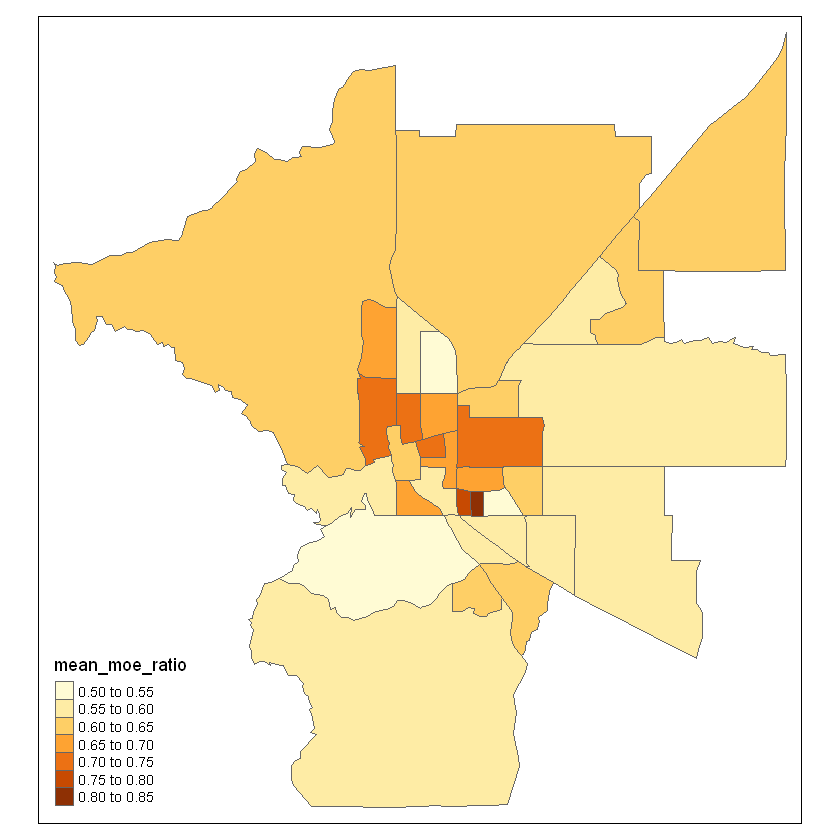

In [20]:
tm_shape(boulder_moe) + 
  tm_polygons(col = "mean_moe_ratio")